# Predicting Waiting Time to Kidney Transplant
### DATA1030 Fall 2022 Project
#### Lindsey Ross

## Loading in the data
**Source**: [Brazil Kidney Waitlist](https://www.kaggle.com/datasets/gustavomodelli/waitlist-kidney-brazil)

**About**: This dataset contains patient information for individuals registered on the waiting list of São Paulo State Organ Allocation System in Brazil between January 1, 2000 and December 29, 2017.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

df = pd.read_csv('../data/waitlist_kidney_brazil.csv', encoding='latin-1')

Many of the values in the dataset are written in Portugese, so they had to be translated to English:

In [3]:
df.replace(to_replace= 'Não' , value= 'N', inplace=True)
df.replace(to_replace= 'Sim' , value= 'Y', inplace=True)
df.replace(to_replace= 'Óbito Lista' , value= 'DeathList', inplace=True)
df['age_cat'].replace(to_replace= '18.a.60' , value= 'From18to60', inplace=True)
df['age_cat'].replace(to_replace= 'Maior.60' , value= 'Over60', inplace=True)
df['age_cat'].replace(to_replace= 'Menor.18' , value= 'Below18', inplace=True)
df['cPRA_cat'].replace(to_replace= 'Entre_0_50' , value= 'ZeroTo50', inplace=True)
df['cPRA_cat'].replace(to_replace= 'Entre_50_80' , value= 'From50To80', inplace=True)
df['cPRA_cat'].replace(to_replace= 'Maior_80' , value= 'Over80', inplace=True)
df.replace(to_replace= 'Outras' , value= 'Other', inplace=True)
df.replace(to_replace= 'HAS' , value= 'Hemolytic uremic syndrome (HUS)', inplace=True)
df.replace(to_replace= 'Diabetes' , value= 'Diabetes', inplace=True)
df.replace(to_replace= 'GNC' , value= 'Glumerulo-Nephrotic Syndrome (GNS)', inplace=True)
df.replace(to_replace= 'Pielonefrite' , value= 'Pylonephritis (PN)', inplace=True)

df.rename(columns = {'anti.HBc':'HBc_antibodies', 'anti.HCV':'HCV_antibodies'}, inplace=True)

In [4]:
# print(df['date_acutal'].value_counts())
# print(df['priorization'].value_counts())

# every value in prioritization is N
# every value in date_acutal is 43307
# the X36MthsTx column is redundant

df.drop(columns=['priorization'],inplace=True)
df.drop(columns=['date_acutal'],inplace=True)
df.drop(columns=['X36MthsTx'],inplace=True)

## Initial EDA

In [5]:
print(df.dtypes)

Id                              int64
date                           object
age_at_list_registration        int64
age_cat                        object
time_on_Dialysis              float64
race                           object
sex                            object
underline_disease              object
diabetes                        int64
Blood_type                     object
number_transfusion              int64
gestation                      object
number_gestation              float64
prior_transplant               object
number_prior_transplant         int64
subregion                      object
cPRA                            int64
cPRA_cat                       object
HLA_A1                          int64
HLA_A2                          int64
HLA_B1                          int64
HLA_B2                          int64
HLA_DR1                         int64
HLA_DR2                         int64
DR_00                          object
B_00                           object
A_00        

In [6]:
print(df.shape)

(48153, 50)


The dataset has information regarding 50 features of 48153 patients on the kidney waitlist.

The target variable is the time since joining the waitlist. There are two different columns that represent this information: 'time' or 'Time_Tx'. The 'time' column is measured in days whereas the 'Time_Tx' column is measured in months, but otherwise these two columns show the exact same information.

In [7]:
# target variable can be time or Time_Tx

print(df['time'].describe())
print(df['Time_Tx'].describe())
print(df['Time_Tx'].value_counts())

count    48153.000000
mean      1090.576350
std        955.582713
min          0.000000
25%        414.000000
50%        800.000000
75%       1470.000000
max       6776.000000
Name: time, dtype: float64
count    48153.000000
mean        35.527375
std         30.977942
min          0.000000
25%         13.670000
50%         26.300000
75%         47.670000
max        225.870000
Name: Time_Tx, dtype: float64
12.17     1471
15.17      241
15.20      106
18.17      101
17.97       80
          ... 
216.53       1
80.70        1
158.80       1
158.23       1
129.47       1
Name: Time_Tx, Length: 4242, dtype: int64


The target variable is continuous. Below is a visualization of the distribution of the target variable.

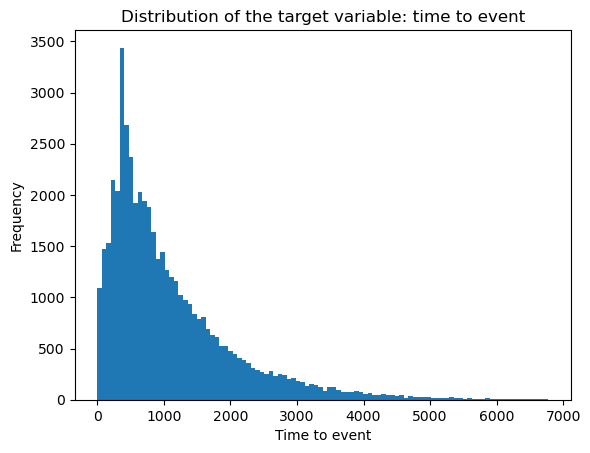

In [37]:
tv = 'time'
df[tv].plot.hist(bins=100)
plt.xlabel('Time to event')
plt.title('Distribution of the target variable: time to event')
plt.savefig('../figures/time_to_event_distribution.png')
plt.show()

Comparing the time to event (Time_Tx) and whether or not the patient received a transplant.

12        4.53
14        8.93
15       44.83
27       42.77
28       15.47
         ...  
48127    45.57
48131    44.80
48137    51.00
48139    22.83
48146    14.03
Name: Time_Tx, Length: 13732, dtype: float64
0        13.07
1        68.87
2        12.17
3        12.17
4         6.47
         ...  
48148    11.47
48149    97.30
48150    41.23
48151     8.40
48152    20.17
Name: Time_Tx, Length: 34421, dtype: float64


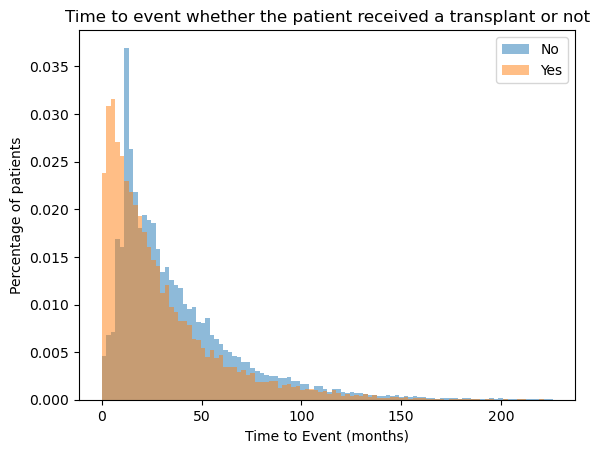

In [10]:
print(df[df['Transplant_Y_N']=='Y']['Time_Tx'])
print(df[df['Transplant_Y_N']=='N']['Time_Tx'])

cats = df['Transplant_Y_N'].unique()
bin_range = (df['Time_Tx'].min(),df['Time_Tx'].max())

for c in cats:
    plt.hist(df[df['Transplant_Y_N']==c]['Time_Tx'],
             alpha=0.5,label=c,range=bin_range,
             bins=100,density=True)
plt.legend(['No', 'Yes'])
plt.ylabel('Percentage of patients')
plt.xlabel('Time to Event (months)')
plt.title('Time to event whether the patient received a transplant or not')
plt.savefig('../figures/time_to_event_transplant_y_n.png')
plt.show()

In [22]:
age_cat_order = ['Below18','From18to60','Over60']
# pd.value_counts(df['age_cat']).reindex(age_cat_order).plot.bar()
# df.plot.bar(x=df['age_cat'], y=df['Time_Tx'])
count_matrix = df.groupby(['age_cat', 'Transplant_Y_N']).size().unstack()
print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)

Transplant_Y_N      N      Y
age_cat                     
Below18           524   1102
From18to60      24241  10511
Over60           9656   2119
Transplant_Y_N         N         Y
age_cat                           
Below18         0.322263  0.677737
From18to60      0.697543  0.302457
Over60          0.820042  0.179958


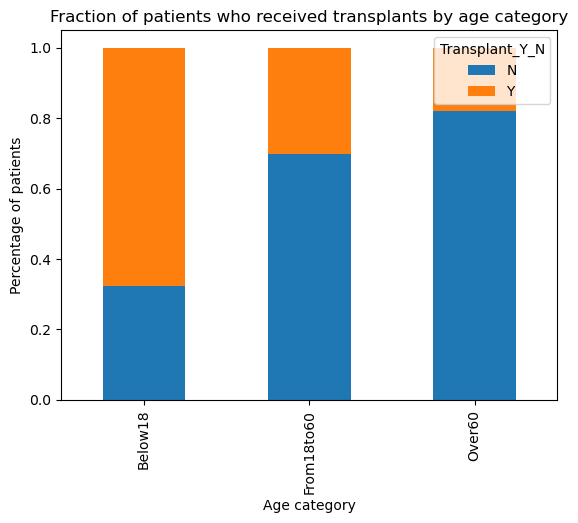

In [23]:
count_matrix_norm.plot.bar(stacked=True)
plt.xlabel('Age category')
plt.ylabel('Percentage of patients')
plt.title('Fraction of patients who received transplants by age category')
plt.savefig('../figures/transplant_y_n_by_age_cat.png')
plt.show()

### Imbalanced data?

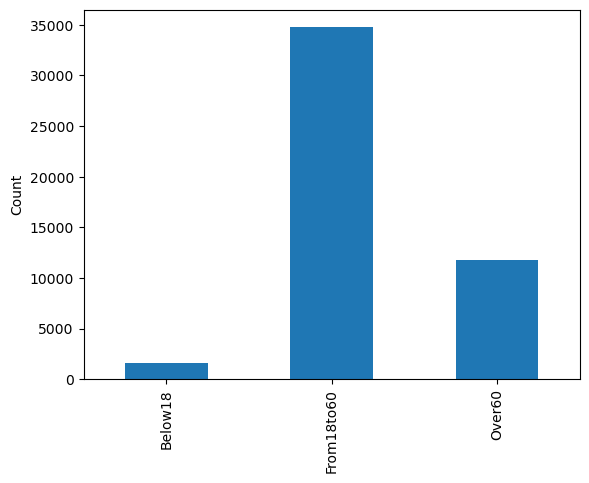

In [32]:
df['age_cat'].value_counts().reindex(age_cat_order).plot.bar()
plt.ylabel('Count')
plt.show()

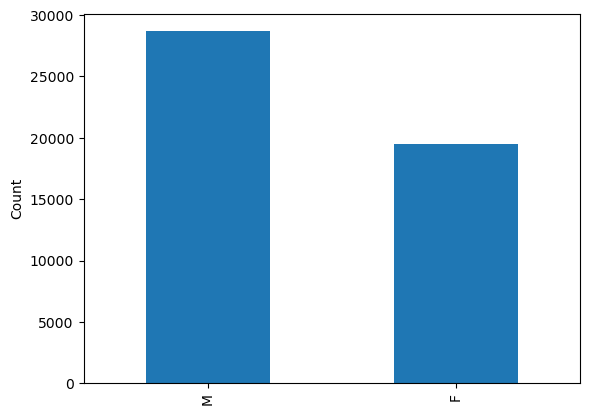

Percentage of patients by sex:
M    0.595685
F    0.404315
Name: sex, dtype: float64


In [33]:
df['sex'].value_counts().plot.bar()
plt.ylabel('Count')
plt.show()
print('Percentage of patients by sex:')
print(df['sex'].value_counts()/len(df))

In [34]:
print('Percentage of patients who received a transplant or did not:')
print(df['Transplant_Y_N'].value_counts()/len(df))

Percentage of patients who received a transplant or did not:
N    0.714826
Y    0.285174
Name: Transplant_Y_N, dtype: float64


## My own exploration/trial and error is below

In [14]:
print(df['razon_removed'].value_counts())

Removido (suspenso > 365 dias)     12985
Transferido para outro Estado        662
Não quer ser transplantado           592
Removido sem condições clínicas      412
Removido pela equipe                 254
Função renal recuperada              212
Abandonou o tratamento                93
Removido administrativo               62
Removido (inscrição duplicada)        17
Transferido de Equipe                  6
Name: razon_removed, dtype: int64


In [15]:
print(df['subregion'].value_counts())

UNIFESP    23166
HCFMUSP    13792
FUNDERP     7791
UNICAMP     3404
Name: subregion, dtype: int64


In [16]:
print(df['age_cat'].value_counts())

From18to60    34752
Over60        11775
Below18        1626
Name: age_cat, dtype: int64


In [17]:
print(df['cPRA_cat'].value_counts())

Zero          34205
ZeroTo50       7311
Over80         3895
From50To80     2742
Name: cPRA_cat, dtype: int64


In [18]:
print(df['underline_disease'].value_counts())

Other                                 16626
Hemolytic uremic syndrome (HUS)       13165
Diabetes                               9987
Glumerulo-Nephrotic Syndrome (GNS)     7234
Pylonephritis (PN)                     1141
Name: underline_disease, dtype: int64


In [19]:
print(df[df['event']==2]['death'].value_counts())

Y    9132
Name: death, dtype: int64
